http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

# p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
# p(sys.version)


In [2]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

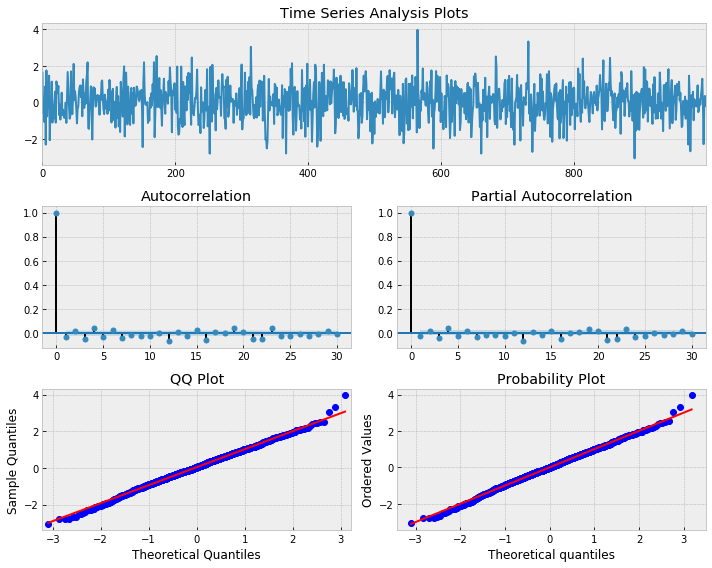

In [4]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

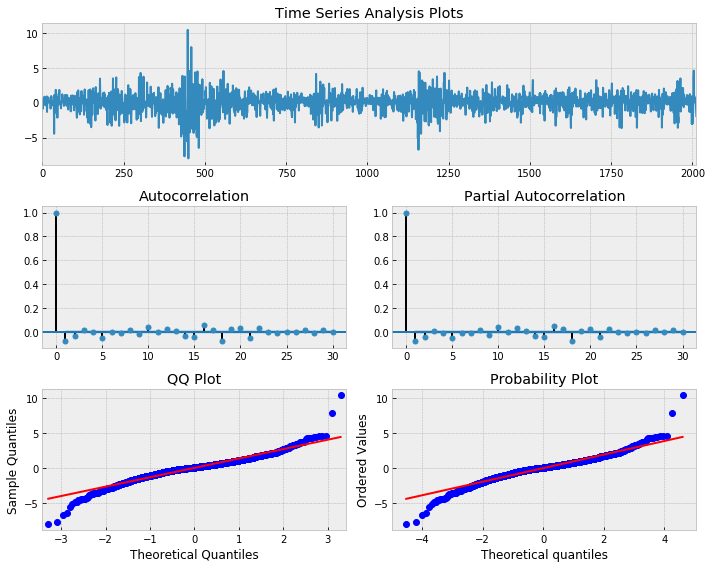

In [5]:
_=tsplot(np.diff(data.SPY),lags=30)

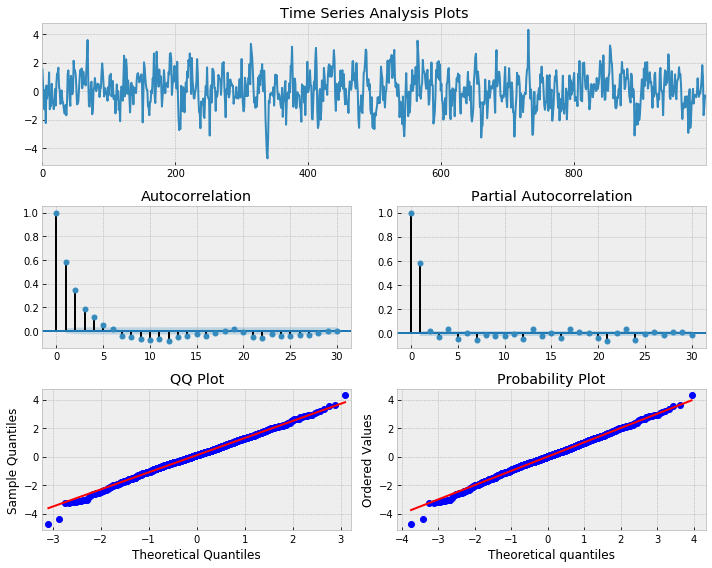

In [6]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

In [7]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

Wall time: 22.1 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


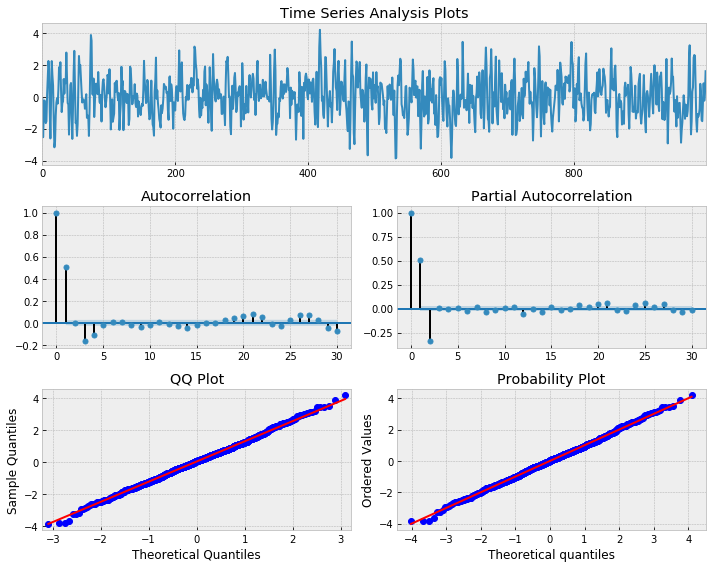

In [8]:
# Simulate an AR(2) process
lags=30
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

In [9]:
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


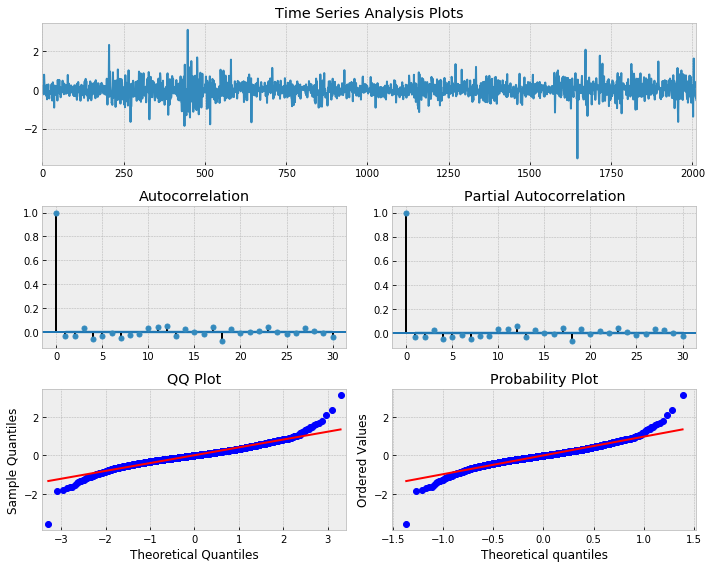

In [10]:
_ = tsplot(np.diff(data.MSFT), lags=lags)

In [11]:
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))


C:\Users\thoma\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\thoma\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 23


In [12]:
return_df=pd.read_excel('return_df.xlsx')
rb=return_df['RB.SHF'].dropna()

ModuleNotFoundError: No module named 'xlrd'

In [ ]:
_=tsplot(rb,lags=30)

In [ ]:
max_lag = 30
mdl = smt.AR(rb).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(rb).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

In [ ]:
mdl.resid.plot()

In [ ]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [ ]:
plt.plot(ma1.cumsum())

In [ ]:

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

In [ ]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [ ]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

In [ ]:
max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

In [ ]:
plt.plot(ma3.cumsum())

In [ ]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

In [ ]:
plt.plot(arma22.cumsum())

In [ ]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()


plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

In [ ]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

In [ ]:
plt.plot(Y.cumsum())

In [ ]:
np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

In [ ]:
_ = tsplot(np.power(eps,2), lags=30)

In [ ]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

In [ ]:
TS = lrets.SPY.loc['2012':'2015']
#res_tup = _get_best_model(TS)
TS.head()
# aic: -5255.56673 | order: (3, 0, 2)
res_tup = _get_best_model(TS)

In [ ]:
order=res_tup[1]


In [ ]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

In [ ]:
rb.cumsum().plot(figsize=(17,7))

In [ ]:
tsplot(rb,lags=30)

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis


In [ ]:
best_aic, best_order, best_mdl=_get_best_model(rb.dropna())

In [ ]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())


In [ ]:
tsplot(res.resid, lags=30)

In [ ]:
(rb.cumsum()+best_mdl.predict())['2015-08'].plot(figsize=(17,7))
(rb.cumsum())['2015-08'].plot(figsize=(17,7))